In [83]:
import pandas as pd
import numpy as np
data = pd.read_csv('accelerometer_data.csv')
data = data.iloc[:397]
data.head()
data['Time_sec'] = data['Time_sec'].astype(float)


In [84]:
# check the missing values and remove the row with the missing values
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)

if missing_values.any():
    data = data.dropna()
    print("Rows with missing values have been removed.")
else:
    print("No missing values found.")

Missing values per column:
Time_ms     0
Time_sec    0
Xa          0
Ya          0
Za          0
dtype: int64
No missing values found.


In [85]:
# remove outliers
from scipy import stats

# Calculate Z-scores for each column, filtering out values beyond a threshold (e.g., Z > 3)
data = data[(np.abs(stats.zscore(data[['Xa', 'Ya', 'Za']])) < 3).all(axis=1)]


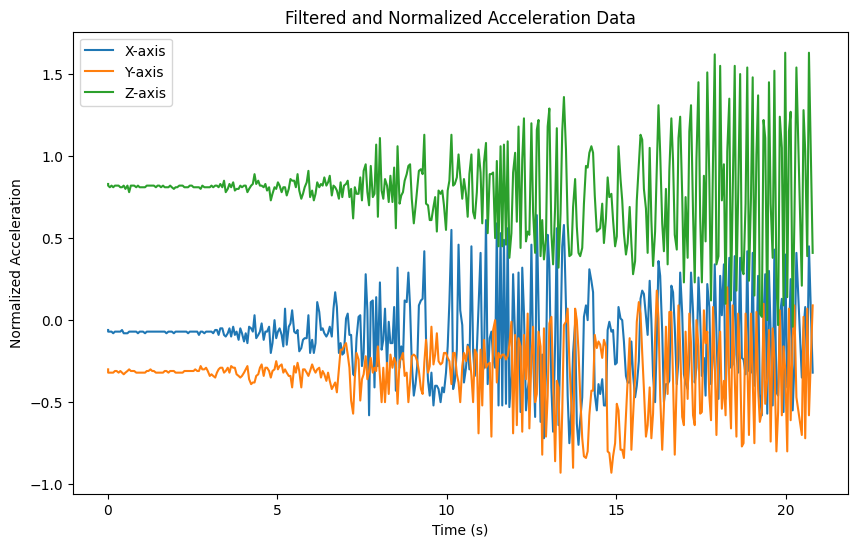

In [86]:
import matplotlib.pyplot as plt

# Plot the filtered acceleration data
plt.figure(figsize=(10, 6))
plt.plot(data['Time_sec'], data['Xa'], label='X-axis')
plt.plot(data['Time_sec'], data['Ya'], label='Y-axis')
plt.plot(data['Time_sec'], data['Za'], label='Z-axis')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Acceleration')
plt.title('Filtered and Normalized Acceleration Data')
plt.legend()
plt.show()


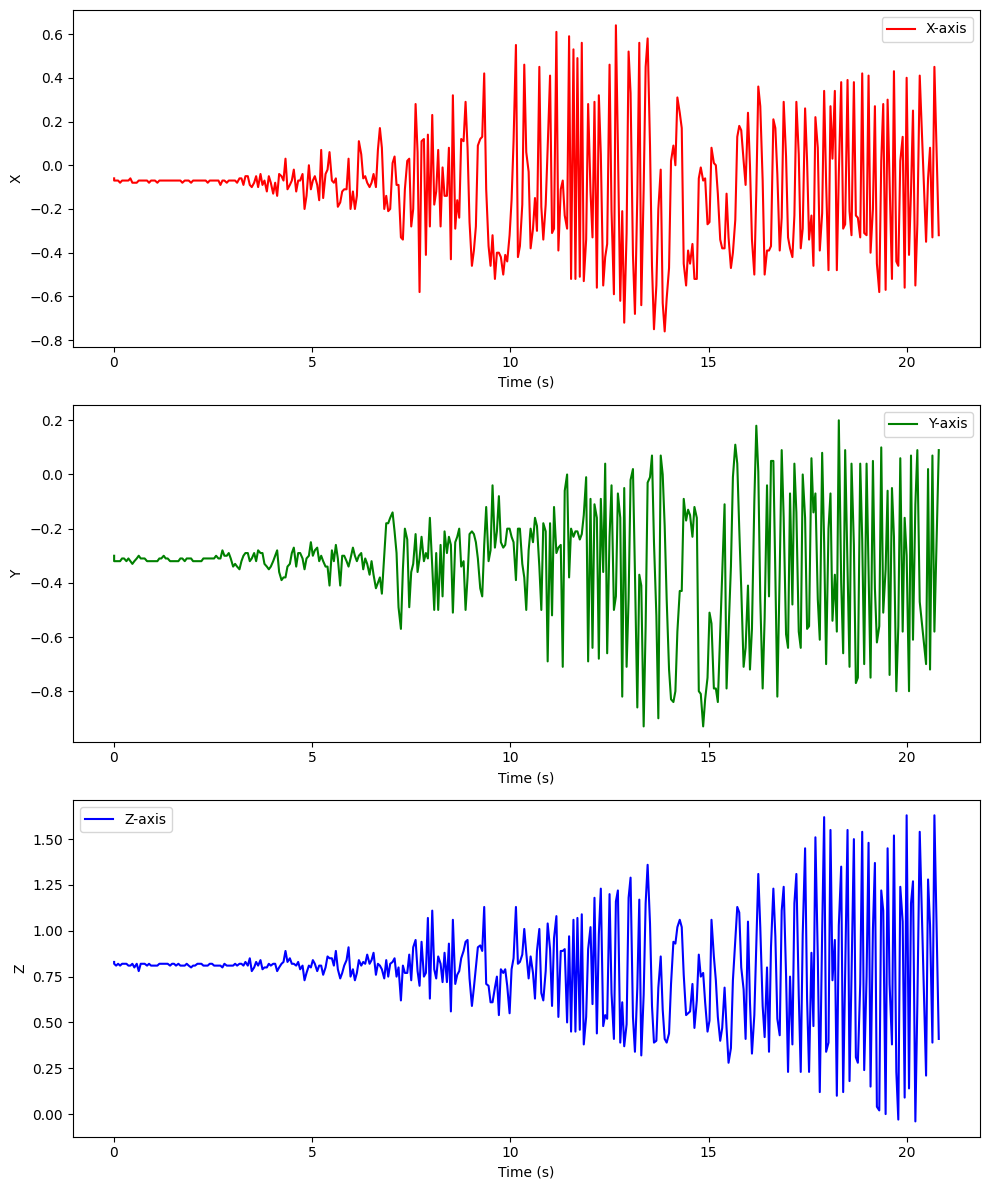

In [87]:
import matplotlib.pyplot as plt

# Set up a figure with three subplots, one for each axis
plt.figure(figsize=(10, 12))

# Plot for X-axis
plt.subplot(3, 1, 1)
plt.plot(data['Time_sec'], data['Xa'], color='r', label='X-axis')
plt.xlabel('Time (s)')
plt.ylabel('X')
plt.legend()

# Plot for Y-axis
plt.subplot(3, 1, 2)
plt.plot(data['Time_sec'], data['Ya'], color='g', label='Y-axis')
plt.xlabel('Time (s)')
plt.ylabel('Y')
plt.legend()

# Plot for Z-axis
plt.subplot(3, 1, 3)
plt.plot(data['Time_sec'], data['Za'], color='b', label='Z-axis')
plt.xlabel('Time (s)')
plt.ylabel('Z')
plt.legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


In [88]:
import numpy as np

# Calculate the time intervals and use it to find the sampling frequency
print(len(data['Time_sec']))
time_intervals = np.diff(data['Time_sec'])  # Get the differences between consecutive time points
average_time_interval = np.mean(time_intervals)
fs = 1 / average_time_interval  # Sampling frequency in Hz
print("Calculated Sampling Frequency (fs):", fs)


390
Calculated Sampling Frequency (fs): 18.710918710918712


FFT Analysis  this can not be used as our data is not evenly spaces

Non uniform FFT


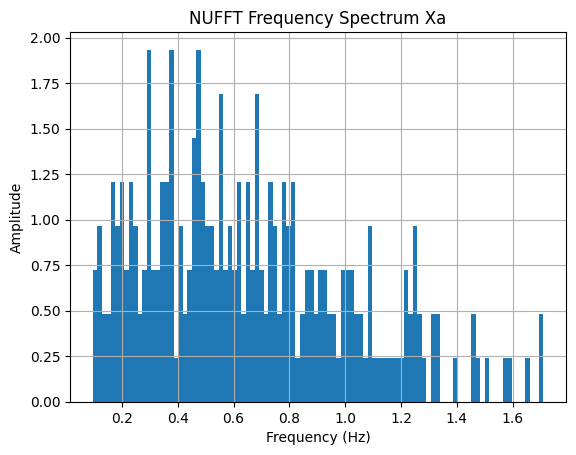

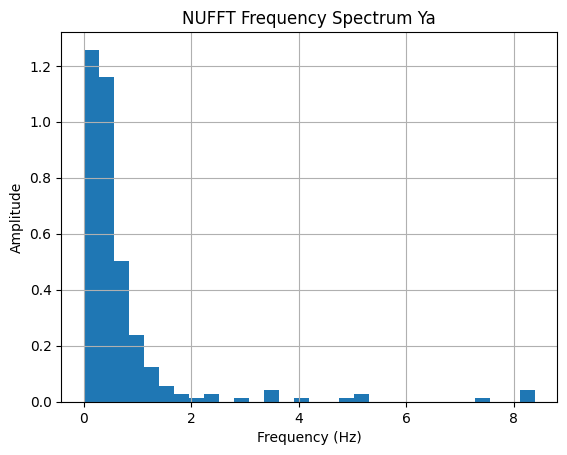

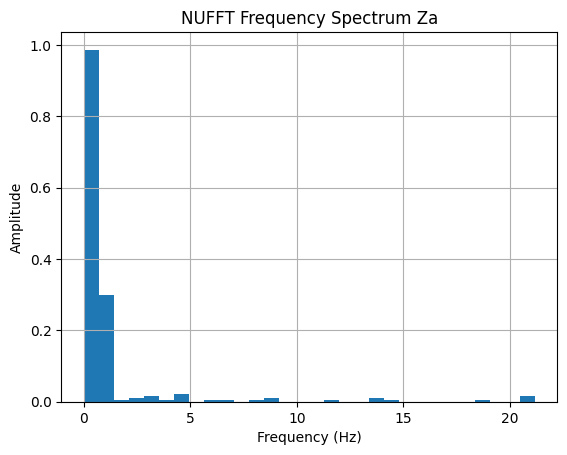

In [92]:
from pynufft import NUFFT
import numpy as np
import matplotlib.pyplot as plt

# Initialize data
time = data['Time_sec'].values  # Numpy array of time values
acceleration_Xa = data['Xa'].values  # Acceleration values along the X-axis
acceleration_Ya = data['Ya'].values  # Acceleration values along the Y-axis
acceleration_Za = data['Za'].values  # Acceleration values along the Z-axis

# Initialize NUFFT object
nufft = NUFFT()

# Scale time points to match NUFFT input expectations (between 0 and 2π)
time_grid = (time / time.max() * 2 * np.pi).reshape(-1, 1)

# Define parameters for NUFFT plan
Nd = (len(acceleration_Xa),)  # Input data size
Kd = (256,)  # Desired output frequency bins size (can be adjusted as needed)
Jd = (6,)  # Number of interpolation points, commonly set around 6 for 1D data

# Plan for the NUFFT for each axis
nufft.plan(time_grid, Nd, Kd, Jd)

# Apply NUFFT to each acceleration axis
transformed_signal_Xa = nufft.forward(acceleration_Xa)
transformed_signal_Ya = nufft.forward(acceleration_Ya)
transformed_signal_Za = nufft.forward(acceleration_Za)

# Frequency range corresponding to Kd (256 bins, from 0 to Nyquist frequency)
sampling_frequency = 18.734  # Replace with your actual sampling frequency in Hz
freqs = np.linspace(0, sampling_frequency / 2, Kd[0])

# Plot the magnitude spectrum for Xa
plt.hist(np.abs(transformed_signal_Xa[:len(freqs)]), bins=100, density=True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('NUFFT Frequency Spectrum Xa')
plt.grid()
plt.show()

# Plot the magnitude spectrum for Ya
plt.hist(np.abs(transformed_signal_Ya[:len(freqs)]), bins=30, density=True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('NUFFT Frequency Spectrum Ya')
plt.grid()
plt.show()

# Plot the magnitude spectrum for Za
plt.hist(np.abs(transformed_signal_Za[:len(freqs)]), bins=30, density=True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('NUFFT Frequency Spectrum Za')
plt.grid()
plt.show()


using non uniform FFT

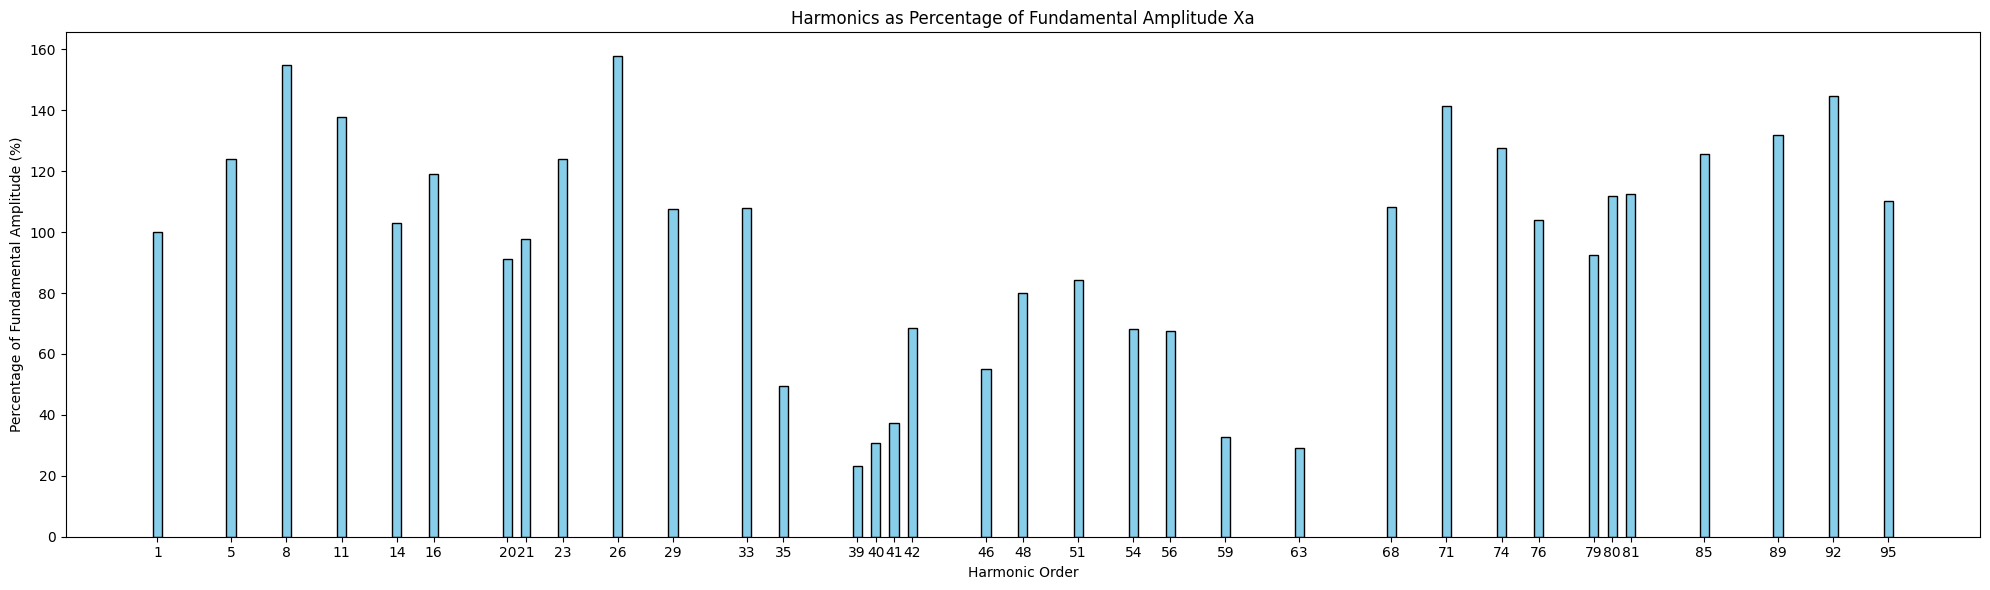

In [90]:
from pynufft import NUFFT
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Initialize data
time = data['Time_sec'].values  # Numpy array 
acceleration = data['Xa'].values

# Initialize NUFFT object
nufft = NUFFT()

# Scale time points to match NUFFT input expectations (between 0 and 2π)
time_grid = (time / time.max() * 2 * np.pi).reshape(-1, 1)

# Define parameters for NUFFT plan
Nd = (len(acceleration),)  # Input data size
Kd = (256,)  # Desired output frequency bins size (can be adjusted as needed)
Jd = (6,)  # Number of interpolation points, commonly set around 6 for 1D data

# Plan for the NUFFT
nufft.plan(time_grid, Nd, Kd, Jd)

# Apply NUFFT to the acceleration data
transformed_signal = nufft.forward(acceleration)

# Calculate the magnitude of the transformed signal
magnitude = np.abs(transformed_signal)

# Find the peaks in the frequency spectrum
peaks, _ = find_peaks(magnitude, height=0.05 * magnitude.max())  # Adjust threshold as needed

# Fundamental frequency
fundamental_idx = peaks[0]  # Assuming the first peak is the fundamental frequency
fundamental_amplitude = magnitude[fundamental_idx]

# Calculate harmonic orders and percentage of the fundamental
harmonic_orders = []
percentage_of_fundamental = []

for peak in peaks:
    # Harmonic order (rounded to the nearest integer)
    order = round(peak / fundamental_idx)
    
    # If it's an integer harmonic (1st, 2nd, 3rd, etc.)
    if order >= 1 and order == peak / fundamental_idx:
        harmonic_orders.append(order)
        percentage_of_fundamental.append((magnitude[peak] / fundamental_amplitude) * 100)

# Plotting the histogram
plt.figure(figsize=(20, 6))
plt.bar(harmonic_orders, percentage_of_fundamental, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Harmonic Order')
plt.ylabel('Percentage of Fundamental Amplitude (%)')
plt.title('Harmonics as Percentage of Fundamental Amplitude Xa')
plt.xticks(harmonic_orders)  # Show each harmonic order on the x-axis
plt.tight_layout()
plt.show()
